# Mar 28, 2024: Total evidence of model classes

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import copy

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations


import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240413-13:05:12,183 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 15 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/density-{args.denst}'
FC_path = f'{ROI_RESULTS_path}/corr_mats'
SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')

0

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [9]:
state = gt.BlockState(gt.Graph(10))
# gt.mcmc_equilibrate()
type(state)._multiflip_mcmc_sweep_parallel_dispatch()

graph_tool.inference.blockmodel.BlockState

In [5]:
def collect_sbm_fits(args, files):
    def get(name):
        l = [s for s in ssr if name in s]
        return l[0].split('-')[-1] if len(l) > 0 else '0'
    
    fits_df = []
    for file in tqdm(files):
        sbm = '_'.join(file.split('/')[-1].split('.')[0].split('_')[:-1])
        ssr = file.split('/')[-2].split('_')
        sub, ses, run = list(map(get, ['sub', 'ses', 'run']))
        
        with open(f'{file}', 'rb') as f:
            [_, L, pmode, _, _, _, bs, _, dls] = pickle.load(f)
        
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'sbm':[sbm],
            'evidence':[L],
        })
        if df['sbm'][0] == 'sbm-p_dc-False':
            continue
        fits_df.append(df)
        
    fits_df = pd.concat(fits_df)
    fits_df = fits_df.sort_values(
        by=['sub', 'ses', 'run']
    ).reset_index(drop=True)

    return fits_df

In [6]:
try:
    fits_df = pd.read_pickle(f'{NPY_path}/fits_df.pkl')
    display(fits_df.head(n=5))
except:
    files = glob.glob(f'{SBM_path}/*/*')
    fits_df = collect_sbm_fits(args, files)
    fits_df = pd.pivot(
        data=fits_df, 
        columns=['sbm'],
        index=['sub', 'ses', 'run'],
        values=['evidence'],
    )
    fits_df.to_pickle(f'{NPY_path}/fits_df.pkl')
    fits_df.head(n=1)

evidence                                                      \
sbm               sbm--a     sbm-dc-d     sbm-dc-h     sbm-dc-o     sbm-nd-d   
sub ses run                                                                    
1   1   0   -4949.999902 -4647.896674 -4591.043863 -4764.532656 -4531.383977   
    2   0   -4759.267057 -4476.768623 -4402.850207 -3261.933339 -4397.886501   
    3   0   -4832.942117 -4500.470383 -4416.294186 -4652.332204 -4411.798836   
2   1   0   -4689.128798 -4406.712209 -4353.127524 -4511.131113 -4343.723893   
    2   0   -4899.636509 -4607.555995 -4554.723687 -4743.625262 -4536.724690   

                                       
sbm             sbm-nd-h     sbm-nd-o  
sub ses run                            
1   1   0   -4440.539592 -4670.402606  
    2   0   -4320.476615 -4544.356674  
    3   0   -4333.006560 -4579.829737  
2   1   0   -4266.934060 -4420.227612  
    2   0   -4462.407417 -4717.513085

[0, 3, 6, 1, 2, 4, 5]


<Axes: ylabel='Count'>

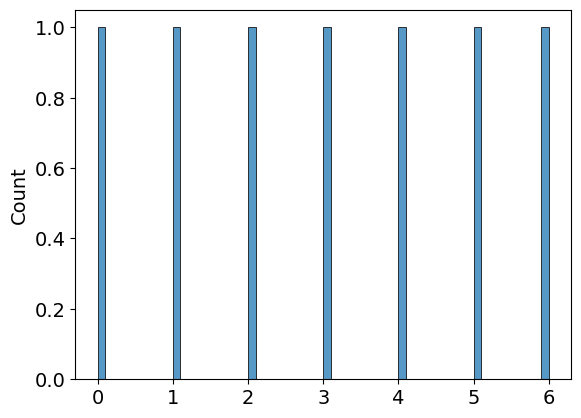

In [7]:
mode_col_idxs = stats.mode(fits_df.apply(np.argsort, axis=1).to_numpy()).mode
mode_col_idxs = list(mode_col_idxs[0])
print(mode_col_idxs)
sns.histplot(mode_col_idxs, binwidth=0.1)

In [8]:
if np.unique(mode_col_idxs).shape[0] == len(mode_col_idxs):
    fits_df_srt = fits_df.reindex(fits_df.columns[mode_col_idxs], axis=1)
else:
    fits_df_srt = fits_df.reindex(fits_df.mean().sort_values().index, axis=1)
fits_df_srt.head(n=5)

evidence                                                      \
sbm               sbm--a     sbm-dc-o     sbm-nd-o     sbm-dc-d     sbm-dc-h   
sub ses run                                                                    
1   1   0   -4949.999902 -4764.532656 -4670.402606 -4647.896674 -4591.043863   
    2   0   -4759.267057 -3261.933339 -4544.356674 -4476.768623 -4402.850207   
    3   0   -4832.942117 -4652.332204 -4579.829737 -4500.470383 -4416.294186   
2   1   0   -4689.128798 -4511.131113 -4420.227612 -4406.712209 -4353.127524   
    2   0   -4899.636509 -4743.625262 -4717.513085 -4607.555995 -4554.723687   

                                       
sbm             sbm-nd-d     sbm-nd-h  
sub ses run                            
1   1   0   -4531.383977 -4440.539592  
    2   0   -4397.886501 -4320.476615  
    3   0   -4411.798836 -4333.006560  
2   1   0   -4343.723893 -4266.934060  
    2   0   -4536.724690 -4462.407417

In [9]:
def paired_permutation_test(args, x, y):
    def statistic(a, b, axis):
            return np.mean(a - b, axis=axis)
    
    # paired samples permutation test
    test = stats.permutation_test(
        data=(x, y),
        statistic=statistic, 
        permutation_type='samples',
        alternative='two-sided',
        n_resamples=int(10000),
        vectorized=True,
        random_state=args.SEED,
        batch=5, 
        axis=0,
    )
    return test

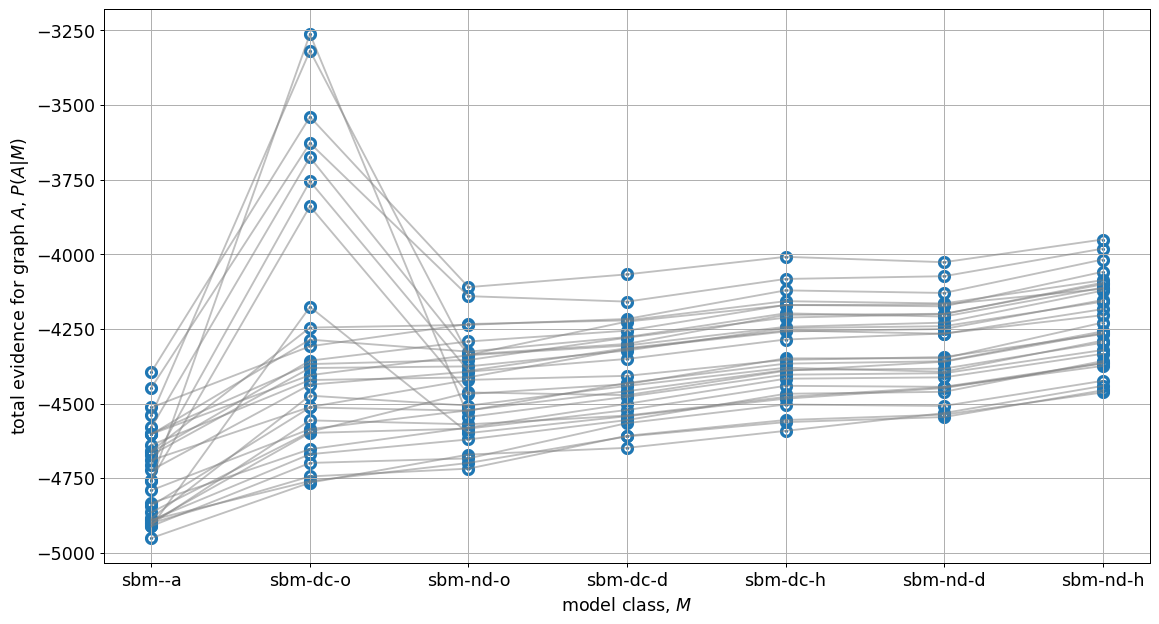

In [10]:
cols = list(zip(*fits_df_srt.columns.to_list()))[1]
fits_df_srt_xy = copy.deepcopy(fits_df_srt)

for idx, (col, vals) in enumerate(fits_df_srt_xy['evidence'].iteritems()):
    fits_df_srt_xy[('evidence', col)] = list(zip([idx]*len(vals), vals.to_numpy()))
fits_df_srt_xy.head(n=5)

fig, axs = plt.subplots(1, 1, figsize=(15, 8), dpi=90)
ax = axs

for col in fits_df_srt_xy.columns:
    x, y = list(zip(*fits_df_srt_xy[col]))
    ax.scatter(*list(zip(*fits_df_srt_xy[col])), s=25, color='tab:blue', marker='.', linewidths=8)
    
for idx in range(len(fits_df_srt_xy.columns[:-1])):
    x1, y1 = list(zip(*fits_df_srt_xy[fits_df_srt_xy.columns[idx]]))
    x2, y2 = list(zip(*fits_df_srt_xy[fits_df_srt_xy.columns[idx+1]]))
    ax.plot([x1, x2], [y1, y2], color='grey', alpha=0.5)
    
ax.set_xticks(np.arange(len(cols)), cols)
ax.set(ylabel='total evidence for graph $A$, $P(A | M)$', xlabel='model class, $M$',)# ylim=[-5100, -3800])
ax.grid(True)

2it [00:00,  5.23it/s]

7it [00:08,  1.18s/it]


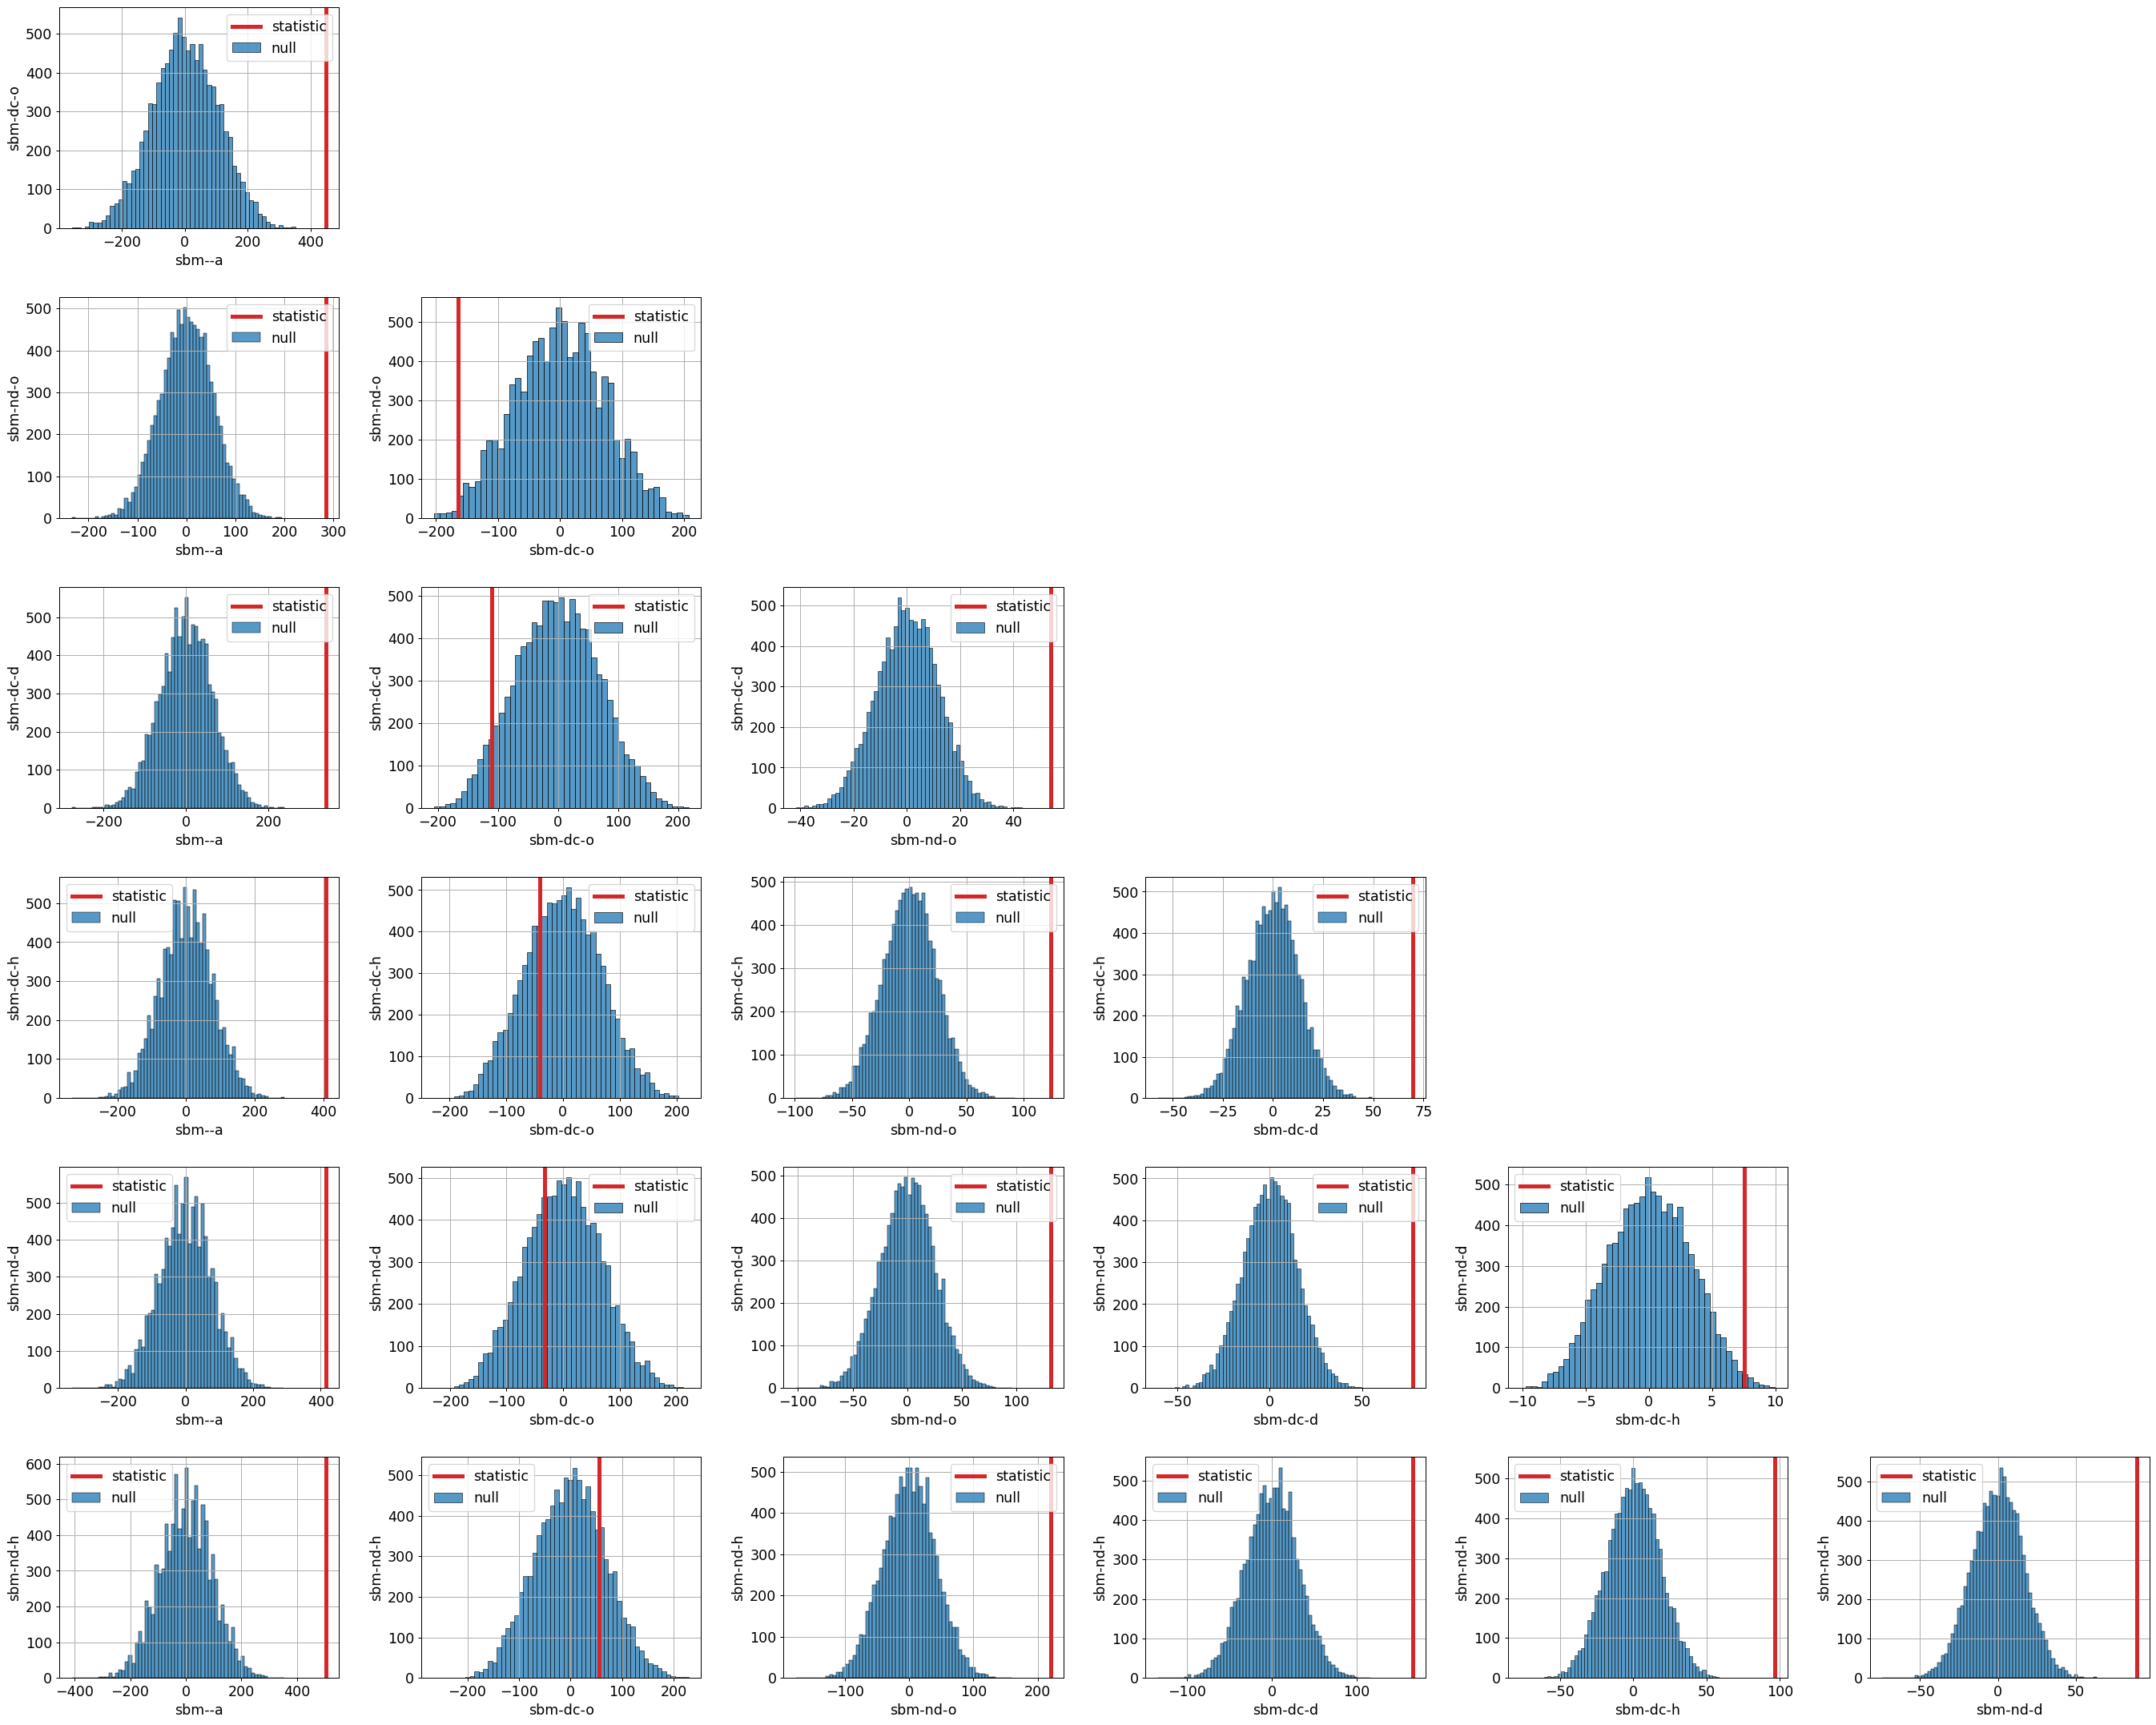

In [11]:
ncols = len(fits_df_srt.columns)
nrows = ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90)
fig.tight_layout(h_pad=3, w_pad=3)
for idx_row, row in tqdm(enumerate(fits_df_srt.columns)):
    for idx_col, col in enumerate(fits_df_srt.columns):
        ax = axs[idx_row, idx_col]
        if idx_col >= idx_row:
            ax.remove()
            continue
        
        x = fits_df_srt[row].to_numpy()
        y = fits_df_srt[col].to_numpy()
        test = paired_permutation_test(args, x, y)
        
        sns.histplot(test.null_distribution, ax=ax, label='null')
        y0, y1 = ax.get_ylim()
        ax.axvline(x=test.statistic, ymin=y0, ymax=y1, color='tab:red', linewidth=4, label='statistic')
        ax.set(ylabel=row[1], xlabel=col[1])
        ax.grid(True)
        ax.legend()